# DDoS Attacks Detection and Characterization


In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime 

In [2]:
df = pd.read_csv('ddos_dataset.csv',low_memory=False)

# we create a copy of the original dataset
df_copy = df.copy()
df

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64235,65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64236,65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64237,65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


# Section 1 – Data exploration and pre-processing

## 1. Investigate the provided DDoS attack dataset

I dati sono stati raccolti il giorno 1 dicembre 2018 dalle 09:17:11 alle 13:34:27. TODO: Da tradurre

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    64239 non-null  int64  
 1   Flow ID                       64239 non-null  object 
 2    Source IP                    64239 non-null  object 
 3    Source Port                  64239 non-null  int64  
 4    Destination IP               64239 non-null  object 
 5    Destination Port             64239 non-null  int64  
 6    Protocol                     64239 non-null  int64  
 7    Timestamp                    64239 non-null  object 
 8    Flow Duration                64239 non-null  int64  
 9    Total Fwd Packets            64239 non-null  int64  
 10   Total Backward Packets       64239 non-null  int64  
 11  Total Length of Fwd Packets   64239 non-null  float64
 12   Total Length of Bwd Packets  64239 non-null  float64
 13   

In [23]:
# we fix column names
df.columns = [col.strip().replace(" ", "") for col in df.columns] 

# we drop the first column which is unnecessary
df.drop(columns=['Unnamed:0'],inplace=True)

# we put 1 when the value of SimilarHTTP is different from zero
df['SimillarHTTP'] = df['SimillarHTTP'].apply(lambda x : 1 if x != 0 else 0)
print(df['SimillarHTTP'].value_counts())
df.head()

KeyError: "['Unnamed:0'] not found in axis"

We now remove columns that have the same value in every row.

In [5]:
unique_val = df.apply(lambda col: col.unique())

col_unique_val = unique_val[unique_val.apply(len) == 1].index

print("Columns meaningless beacuse they have the same value on all rows:")
print(col_unique_val)

df.drop(columns=col_unique_val,inplace=True)

print(f"The dataset has now {df.shape[0]} rows and {df.shape[1]}")

Columns meaningless beacuse they have the same value on all rows:
Index(['BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'FINFlagCount',
       'PSHFlagCount', 'ECEFlagCount', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SimillarHTTP'],
      dtype='object')
The dataset has now 64239 rows and 74


In [5]:
df.describe()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,64239.000000,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,...,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,64239.000000
mean,32637.819876,25267.368608,30715.252884,14.362864,5.150614e+06,18.814848,1.304036,6699.521630,2.153348e+03,613.992948,...,-4.167229e+07,9.026629e+03,4.878774e+03,1.687791e+04,6.204895e+03,1.155553e+06,2.613584e+05,1.555321e+06,8.908522e+05,0.919566
std,19008.473731,24710.413442,20347.990914,4.706001,2.249713e+07,462.305336,25.199720,20510.320389,9.087201e+04,585.691655,...,2.062767e+08,2.045563e+05,1.424082e+05,3.828583e+05,1.667756e+05,5.341380e+06,1.574889e+06,6.993415e+06,4.571276e+06,0.271966
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,...,-1.062719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,16209.500000,779.000000,12435.500000,17.000000,1.000000e+00,2.000000,0.000000,123.000000,0.000000e+00,53.000000,...,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,32477.000000,29661.000000,30797.000000,17.000000,2.000000e+00,2.000000,0.000000,1050.000000,0.000000e+00,393.000000,...,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,48726.500000,48510.500000,49041.500000,17.000000,2.087700e+04,2.000000,0.000000,2944.000000,0.000000e+00,1464.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,65999.000000,65518.000000,65535.000000,17.000000,1.200000e+08,85894.000000,1862.000000,176000.000000,8.829488e+06,3564.000000,...,1.480000e+03,1.678654e+07,2.853681e+07,6.783473e+07,8.349846e+06,1.147455e+08,5.275036e+07,1.147455e+08,1.147455e+08,1.000000


In [24]:
df['FlowID']=df["SourceIP"] + "-" + df["DestinationIP"] + "-" + \
               df["SourcePort"].astype(str) + "-" + \
               df["DestinationPort"].astype(str) + "-" + \
               df["Protocol"].astype(str)
df

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,SimillarHTTP,Inbound,label,label_simplified
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns,attack
1,192.168.50.1-172.16.0.5-634-60495-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,ddos_dns,attack
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns,attack
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns,attack
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns,attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_udp_lag,attack
64235,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_udp_lag,attack
64236,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_udp_lag,attack
64237,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_udp_lag,attack


### BASIC TRAFFIC STATISTICS

In [25]:
n_flow=df['FlowID'].nunique() # 64239
n_src_ip = df["SourceIP"].nunique()
n_dst_ip = df["DestinationIP"].nunique()

print(f"Number of unique source IPs: {n_src_ip}")
print(f"Number of unique destination IPs: {n_dst_ip}")
n_flow

Number of unique source IPs: 216
Number of unique destination IPs: 245


62154

### LABEL DISTRIBUTION

In [26]:
df_masked=df[df['label']=='benign']
num_benign=df_masked['label'].count() # 5658

num_attack=len(df)-num_benign # 58581
num_attackpertype=df[df['label']!='benign'].groupby(["label"]).size()   # int(num_attacktype[i])
num_attackpertype

label
ddos_dns        5369
ddos_ldap       5928
ddos_mssql      5911
ddos_netbios    5830
ddos_ntp         986
ddos_snmp       5984
ddos_ssdp       5970
ddos_syn        5480
ddos_tftp       5261
ddos_udp        5876
ddos_udp_lag    5986
dtype: int64

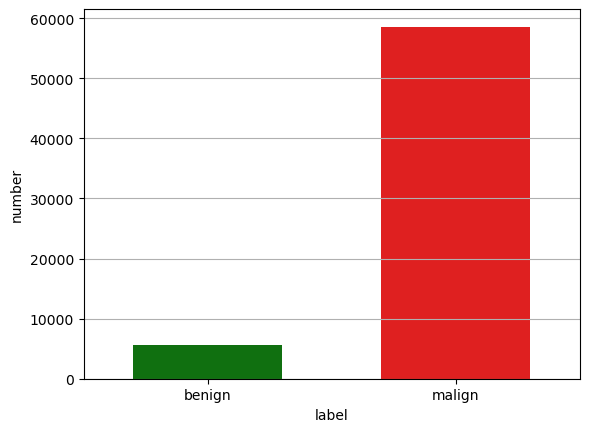

In [45]:
df_benign= pd.DataFrame({
    'label' : ['benign','malign'], 
    'number' : [num_benign, num_attack]
})

sns.barplot(
    data = df_benign, # which dataframe you want to use as the source data
    x = 'label', # which column to use for x-axis
    y = 'number', # which column to use for y-axis
    width=0.6,
    palette = ['green', 'red'],
    hue = 'label',
    legend = False
)
plt.grid(True)             
plt.grid(axis='x')
plt.show()

### TRAFIC LEVEL DISTRIBUITION

#### PROTOCOL

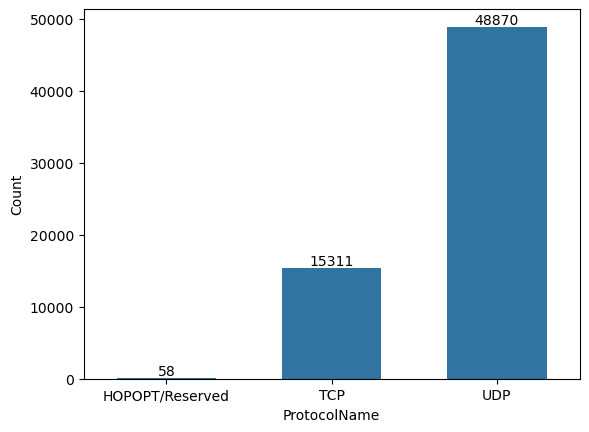

In [52]:
prt_map = {
    6: 'TCP',
    17: 'UDP',
    0: 'HOPOPT/Reserved'
}


df_prot['ProtocolName'] = df['Protocol'].replace(prt_map)

df_prot=df.groupby('ProtocolName')['ProtocolName'].count()
df_prot=pd.DataFrame(df_prot)
df_prot.columns=['Count']

ax = sns.barplot(data = df_prot, x = df_prot.index, y = 'Count', width=0.6)

# Aggiungere i valori sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')
plt.show()

### IP SOURCE/DESTINATION 

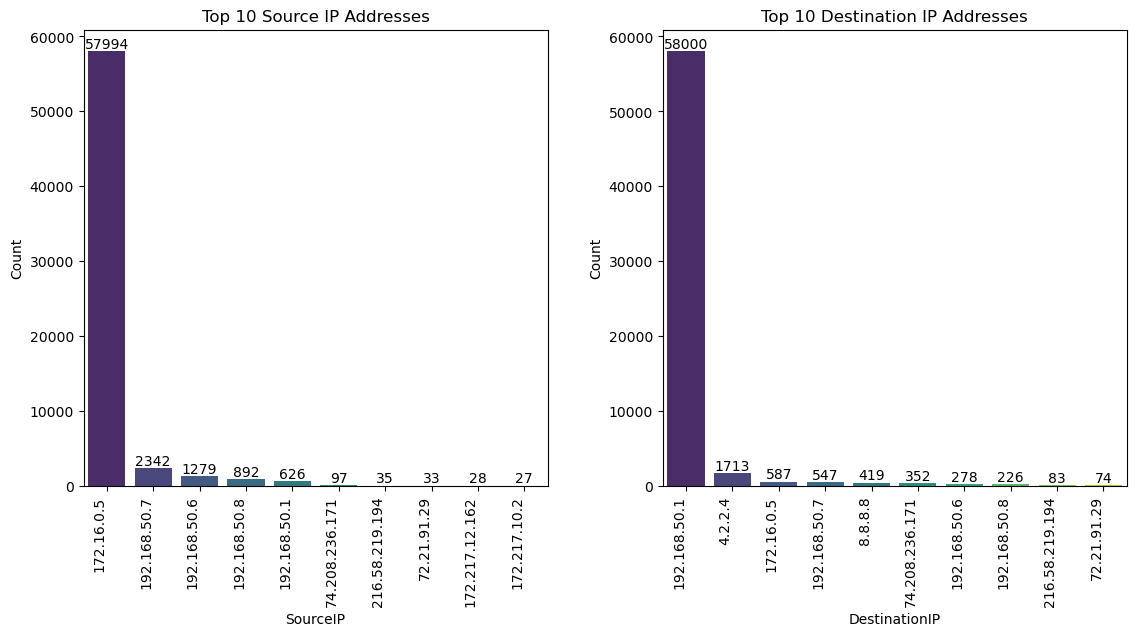

In [126]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
IP_Source_dist = df['SourceIP'].value_counts().head(10)
IP_Source_dist = pd.DataFrame(IP_Source_dist)
IP_Source_dist.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist,
    x = 'SourceIP',
    y = 'Count',
    palette='viridis',
    hue = 'SourceIP',
    legend = False
    
)
plt.title('Top 10 Source IP Addresses')
plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.subplot(1,2,2)
IP_Destination_dist = df['DestinationIP'].value_counts().head(10)
IP_Destination_dist = pd.DataFrame(IP_Destination_dist)
IP_Destination_dist.columns = ['Count']
ax = sns.barplot(
    data = IP_Destination_dist,
    x = 'DestinationIP',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationIP',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Destination IP Addresses')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

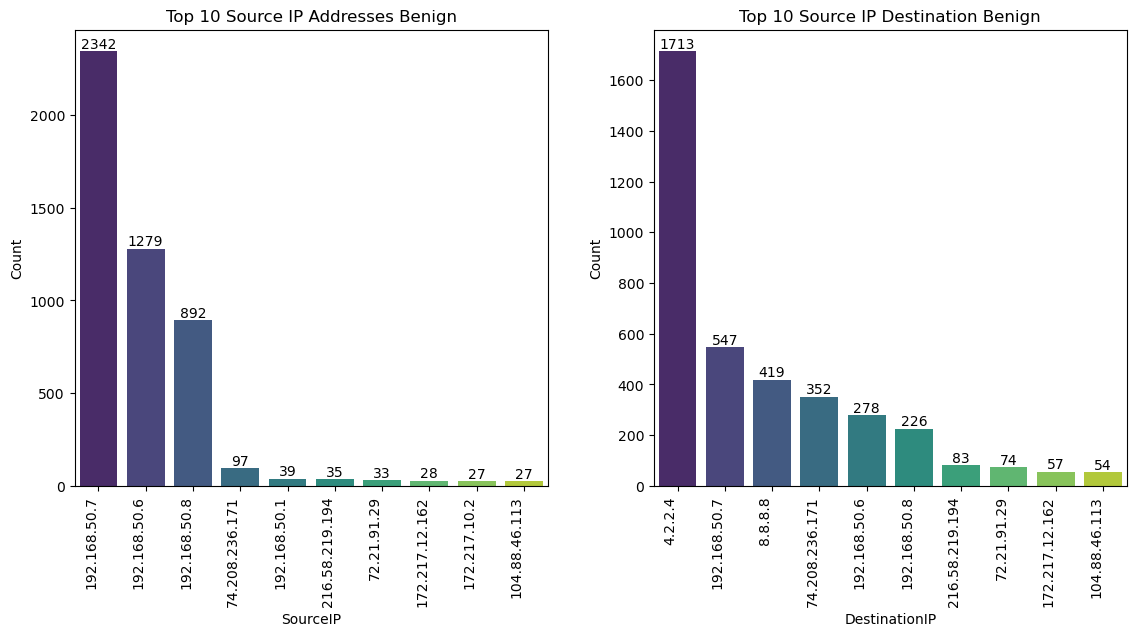

In [127]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
IP_Source_dist_Benign = df['SourceIP'][df['label'] == 'benign'].value_counts().head(10)
IP_Source_dist_Benign = pd.DataFrame(IP_Source_dist_Benign)
IP_Source_dist_Benign.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist_Benign,
    x = 'SourceIP',
    y = 'Count',
    palette='viridis',
    hue = 'SourceIP',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source IP Addresses Benign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.subplot(1,2,2)
IP_Source_dist_Benign = df['DestinationIP'][df['label'] == 'benign'].value_counts().head(10)
IP_Source_dist_Benign = pd.DataFrame(IP_Source_dist_Benign)
IP_Source_dist_Benign.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist_Benign,
    x = 'DestinationIP',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationIP',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source IP Destination Benign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

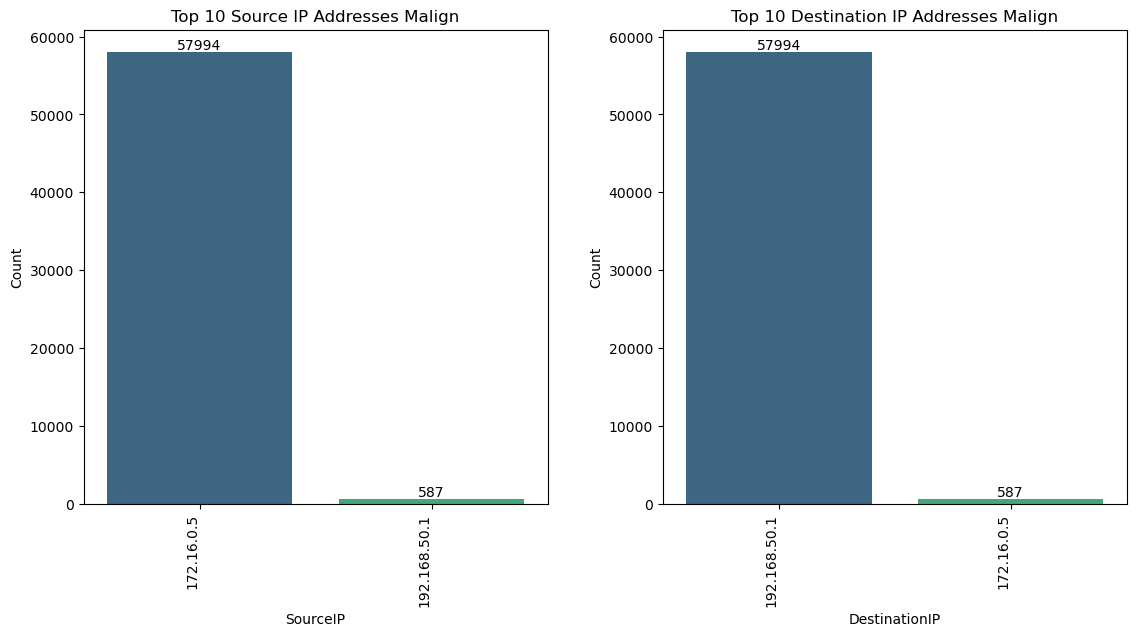

In [128]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
IP_Source_dist_Malign = df['SourceIP'][df['label'] != 'benign'].value_counts().head(10)
IP_Source_dist_Malign = pd.DataFrame(IP_Source_dist_Malign)
IP_Source_dist_Malign.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist_Malign,
    x = 'SourceIP',
    y = 'Count',
    palette='viridis',
    hue = 'SourceIP',
    legend = False
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source IP Addresses Malign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.subplot(1,2,2)
IP_Destination_dist_Malign = df['DestinationIP'][df['label'] != 'benign'].value_counts().head(10)
IP_Destination_dist_Malign = pd.DataFrame(IP_Destination_dist_Malign)
IP_Destination_dist_Malign.columns = ['Count']
ax = sns.barplot(
    data = IP_Destination_dist_Malign,
    x = 'DestinationIP',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationIP',
    legend = False
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Destination IP Addresses Malign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')




plt.tight_layout(pad=3)

In [35]:
df['label_simplified']= df['label'].apply(lambda x: "benign" if x=='benign' else "attack")

<Axes: xlabel='DestinationPort', ylabel='Proportion'>

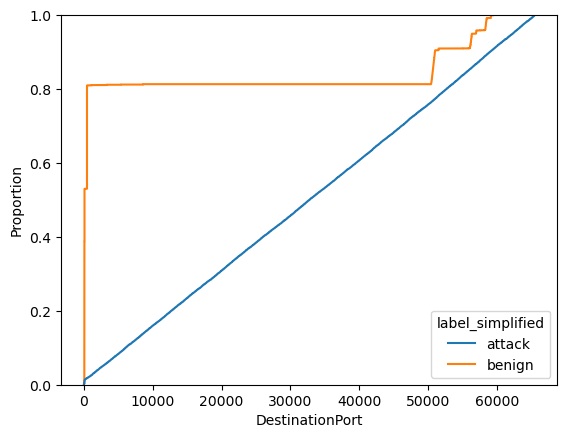

In [36]:
sns.ecdfplot(
    data = df,
    x = 'DestinationPort', # the column that you want to compute ecdf, they will be in the order from short to long length (numerical order)
    hue = 'label_simplified')

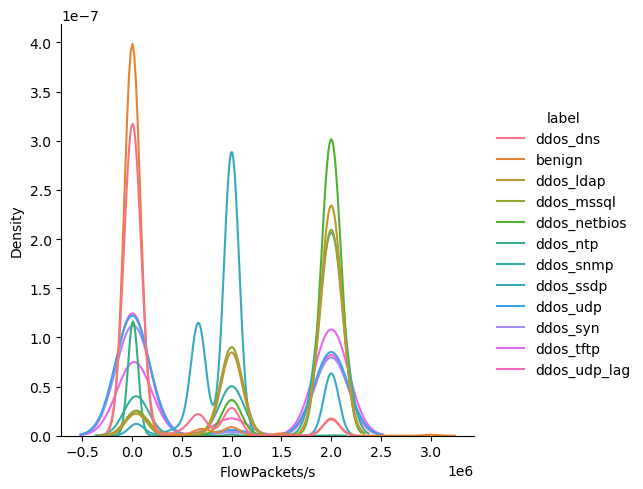

In [14]:
sns.displot(
    data = df, 
    x = "FlowPackets/s", # the column you want to check
    hue = "label", # check the distribution of different flower types
    kind = "kde" # a kernel density estimate (KDE) of the distribution, you can remove this to see the change
)

/tmp/ipykernel_11522/1905931592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masked['Timestamp'] = pd.to_datetime(df_masked['Timestamp'])


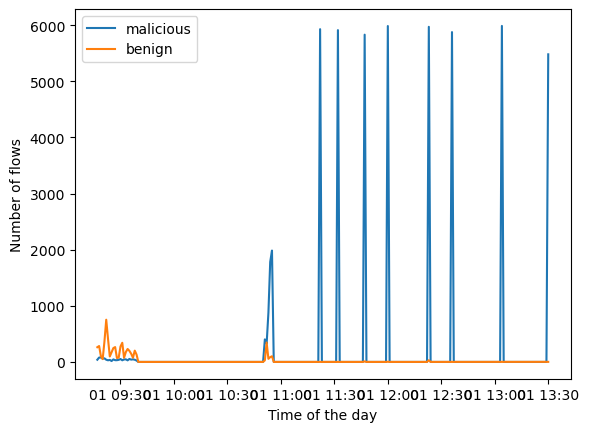

In [16]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_masked['Timestamp'] = pd.to_datetime(df_masked['Timestamp'])

df_time_b=df_masked.set_index('Timestamp')
df_time_b=df_time_b.resample('1min').size()

df_time=df.set_index('Timestamp')
df_time=df_time.resample('1min').size()
df_time_m=df_time-df_time_b

plt.figure()
sns.lineplot(data = df_time_m, label='malicious')
sns.lineplot(data = df_time_b,label='benign')
plt.xlabel("Time of the day")
plt.ylabel("Number of flows")
plt.show()

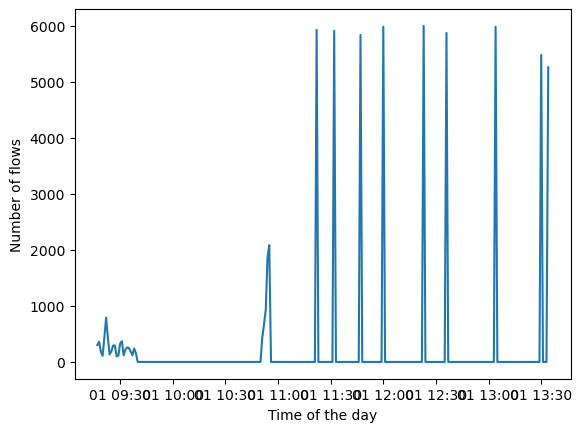

In [17]:
plt.figure()
sns.lineplot(data = df_time)
plt.xlabel("Time of the day")
plt.ylabel("Number of flows")
plt.show()

## 2. Generate additional features

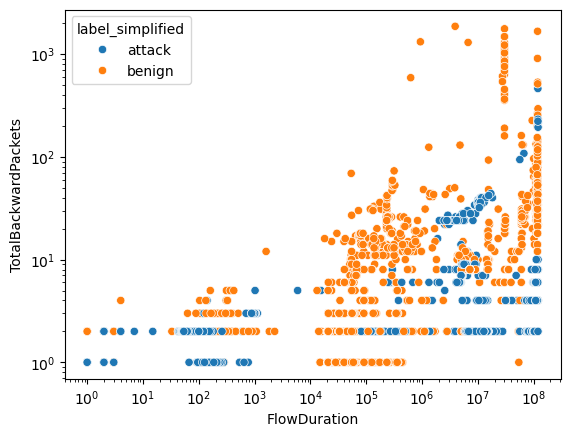

In [18]:
df['TotalBytes'] = df['TotalLengthofFwdPackets'] + df['TotalLengthofBwdPackets']
df['TotalPackets'] = df['TotalFwdPackets'] + df['TotalBackwardPackets']
df['AveragePacketLength'] = df['TotalBytes'] / df['TotalPackets']

df['Fwd/BwdPacketRatio'] = df['TotalFwdPackets'] / (df['TotalBackwardPackets'] + 1)

df['TrafficScore'] = df['TotalBytes'] * df['FlowPackets/s']

sns.scatterplot(
    data=df,
    x='FlowDuration',
    y='TotalBackwardPackets', # ????????
    hue='label_simplified') 
plt.xscale('log')
plt.yscale('log')
plt.show()

### Time

In [19]:
reference_date = min(df['Timestamp'])
df['Timestamp'] = (df['Timestamp'] - reference_date).dt.total_seconds()

## Categorial features encoding

In [20]:
#Funzione per convertire IP in intero, qui convertiamo i source ip
def ip_to_int(ip):
    try:
        # Funziona sia per IPv4 che per IPv6
        return int(ipaddress.ip_address(ip))
    except:
        # Se c'è un errore (es. valore nullo o stringa errata), ritorna None o -1
        return None

#Applicare la funzione alla colonna 'Src IP'
df['SourceIpInt'] = df['SourceIP'].apply(ip_to_int)
df['DestinationIPInt'] = df['DestinationIP'].apply(ip_to_int)

print(df[['SourceIP', 'SourceIpInt']].head())
print(df[['DestinationIP', 'DestinationIPInt']].head())

df.info()
#si creeranno due colonne nuove con gli IP convertiti in interi

#Convert 'Timestamp' to seconds since the first timestamp
reference_date = min(df['Timestamp'])
df['Timestamp'] = (df['Timestamp']-reference_date).dt.total_seconds()

       SourceIP SourceIpInt
0    172.16.0.5        None
1  192.168.50.1        None
2    172.16.0.5        None
3    172.16.0.5        None
4    172.16.0.5        None
  DestinationIP DestinationIPInt
0  192.168.50.1             None
1    172.16.0.5             None
2  192.168.50.1             None
3  192.168.50.1             None
4  192.168.50.1             None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 82 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FlowID                   64239 non-null  object 
 1   SourceIP                 64239 non-null  object 
 2   SourcePort               64239 non-null  int64  
 3   DestinationIP            64239 non-null  object 
 4   DestinationPort          64239 non-null  int64  
 5   Protocol                 64239 non-null  int64  
 6   Timestamp                64239 non-null  float64
 7   FlowDuration             64239 non

AttributeError: Can only use .dt accessor with datetimelike values

## 3. Data Pre-processing

### Correlation matrix

In [ ]:
from sklearn.decomposition import PCA

# Compute the correlation matrix
correlation_matrix = df.drop(columns=['label','label_simplified']).corr().abs()

# Compute the heatmap
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

### PCA

In [ ]:
pca = PCA(random_state=42)
pca.fit(df)

# cella sotto ancora da modificare ....

In [ ]:
# describe how much of the dataset variability is indicated by a given amount of features
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(4)], [i for i in range(1,5)])
plt.grid()
plt.title(f'3 PCs explain {round(perc_cumul_exp_var[2], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()